In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy as sa
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func, Table, Column, Integer, String, Date, Float

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model

inspector = inspect(engine)



In [9]:
meas_columns = inspector.get_columns('measurement')
for c in meas_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
stat_columns = inspector.get_columns('station')
for c in stat_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# View all of the classes that automap found

# reflect the tables

inspector.get_table_names()



['measurement', 'station']

In [12]:
# Save references to table measurement 
Base = automap_base()
Base.prepare(autoload_with=engine)
Measurement = Base.classes.measurement
Measurement

sqlalchemy.ext.automap.measurement

In [13]:
# Save references to table measurement
Station = Base.classes.station
Station

sqlalchemy.ext.automap.station

In [14]:
# Create our session (link) from Python to the DB

session = Session(engine)

In [15]:
# see the date (column's format)

result = engine.execute('SELECT date FROM measurement order by 1 desc').fetchall()
result

[('2017-08-23',),
 ('2017-08-23',),
 ('2017-08-23',),
 ('2017-08-23',),
 ('2017-08-22',),
 ('2017-08-22',),
 ('2017-08-22',),
 ('2017-08-21',),
 ('2017-08-21',),
 ('2017-08-21',),
 ('2017-08-21',),
 ('2017-08-20',),
 ('2017-08-20',),
 ('2017-08-20',),
 ('2017-08-19',),
 ('2017-08-19',),
 ('2017-08-19',),
 ('2017-08-19',),
 ('2017-08-18',),
 ('2017-08-18',),
 ('2017-08-18',),
 ('2017-08-18',),
 ('2017-08-17',),
 ('2017-08-17',),
 ('2017-08-17',),
 ('2017-08-17',),
 ('2017-08-16',),
 ('2017-08-16',),
 ('2017-08-16',),
 ('2017-08-16',),
 ('2017-08-15',),
 ('2017-08-15',),
 ('2017-08-15',),
 ('2017-08-15',),
 ('2017-08-15',),
 ('2017-08-14',),
 ('2017-08-14',),
 ('2017-08-14',),
 ('2017-08-14',),
 ('2017-08-14',),
 ('2017-08-13',),
 ('2017-08-13',),
 ('2017-08-13',),
 ('2017-08-13',),
 ('2017-08-13',),
 ('2017-08-12',),
 ('2017-08-12',),
 ('2017-08-12',),
 ('2017-08-11',),
 ('2017-08-11',),
 ('2017-08-11',),
 ('2017-08-11',),
 ('2017-08-10',),
 ('2017-08-10',),
 ('2017-08-10',),
 ('2017-08

# Exploratory Precipitation Analysis

In [89]:
# Find the most recent date in the data set.

sel = [func.max(func.strftime("%Y-%m-%d",Measurement.date))]

recent_date = session.query(*sel).scalar()
recent_date

'2017-08-23'

In [96]:
# conver str date to a date object

query_date = dt.datetime.strptime(str(recent_date), "%Y-%m-%d").date()
query_date

datetime.date(2017, 8, 23)

In [98]:

# Calculate the date one year from the last date in data set.

query_date = query_date - dt.timedelta(days=365)
query_date

datetime.date(2015, 8, 24)

In [100]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Execute query

result_Station = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

result_df = pd.DataFrame(result_Station, columns=["date","precipitation"])


In [101]:
result_df['date'] =  pd.to_datetime(result_df['date'], format='%Y-%m-%d')

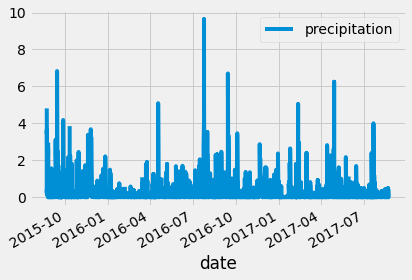

In [103]:
result_df.plot(x="date",y="precipitation") 

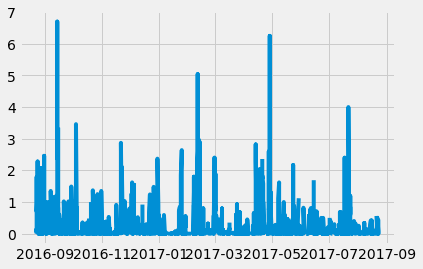

In [41]:
# Use numpy Plotting with Matplotlib to plot the data

fig, ax = plt.subplots()
ax.plot(result_df['date'], result_df['precipitation'])

In [105]:
# Use Pandas to calculate the summary statistics for the precipitation data
result_df["precipitation"].describe()

count    4091.000000
mean        0.205634
std         0.529369
min         0.000000
25%         0.000000
50%         0.020000
75%         0.160000
max         9.640000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [106]:
# Design a query to calculate the total number stations in the dataset

sel = [func.count(Station.station)]

stations_query = session.query(*sel).scalar()
stations_query

print(f"The number of stations is ",stations_query)

The number of stations is  9


In [107]:
sel = [Measurement.station, 
       func.count(Measurement.id)]

# Design a query to find the most active stations (i.e. what stations have the most rows?)

stations_first_query = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
stations_first_query 



('USC00519281', 2772)

In [108]:
# List the stations and the counts in descending order.

stations_active_query = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
stations_active_query 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [109]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

station_value = 'USC00519281'

sel = [func.min(Measurement.prcp),
       func.max(Measurement.prcp),
       func.avg(Measurement.prcp)]

station_temp_query = session.query(*sel).filter(Measurement.station==station_value).order_by(func.count(Measurement.id).desc()).all()
station_temp_query

[(0.0, 9.64, 0.2123520923520915)]

In [110]:
sel = [func.max(func.strftime("%Y-%m-%d",Measurement.date))]

recent_date_station = session.query(*sel).filter(Measurement.station==station_value).scalar()
recent_date_station

'2017-08-18'

In [111]:
#query_date = dt.datetime.strptime(str(recent_date_station), "%Y-%m-%d").date()
query_date = query_date - dt.timedelta(days=365)
query_date


datetime.date(2014, 8, 24)

In [112]:
result_Station = session.query(Measurement.date, Measurement.prcp).filter(Measurement.station==station_value).filter(Measurement.date >= query_date).order_by(Measurement.date).all()
result_Station

[('2014-08-24', 0.17),
 ('2014-08-25', 0.01),
 ('2014-08-26', 0.38),
 ('2014-08-27', 0.22),
 ('2014-08-28', 0.01),
 ('2014-08-29', 0.06),
 ('2014-08-30', 0.11),
 ('2014-08-31', 0.0),
 ('2014-09-01', 0.0),
 ('2014-09-02', 2.29),
 ('2014-09-03', 0.02),
 ('2014-09-04', 0.0),
 ('2014-09-05', 0.06),
 ('2014-09-06', 0.61),
 ('2014-09-07', 0.01),
 ('2014-09-08', 0.0),
 ('2014-09-09', 0.0),
 ('2014-09-10', 0.0),
 ('2014-09-11', 0.02),
 ('2014-09-12', 0.09),
 ('2014-09-13', 0.0),
 ('2014-09-14', 0.0),
 ('2014-09-15', 0.53),
 ('2014-09-16', 0.0),
 ('2014-09-17', 0.47),
 ('2014-09-18', 0.04),
 ('2014-09-19', 0.18),
 ('2014-09-20', 0.14),
 ('2014-09-21', 1.21),
 ('2014-09-22', 0.06),
 ('2014-09-23', 0.01),
 ('2014-09-24', 0.0),
 ('2014-09-25', 0.12),
 ('2014-09-26', 0.38),
 ('2014-09-27', 0.09),
 ('2014-09-28', 0.26),
 ('2014-09-29', 0.55),
 ('2014-09-30', 0.3),
 ('2014-10-01', 4.0),
 ('2014-10-02', 0.02),
 ('2014-10-03', 0.37),
 ('2014-10-04', 0.4),
 ('2014-10-05', 0.95),
 ('2014-10-06', 0.1),
 (

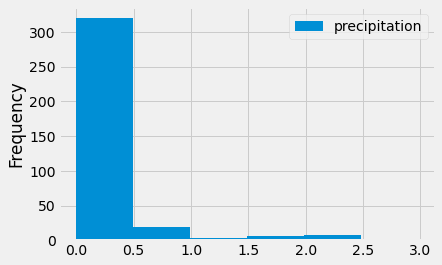

In [113]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 

sel = [func.max(func.strftime("%Y-%m-%d",Measurement.date))]

recent_date_station = session.query(*sel).filter(Measurement.station==station_value).scalar()

# convert a date type
query_date = dt.datetime.strptime(str(recent_date_station), "%Y-%m-%d").date()

# Calculate the date one year from the last date in data set.

query_date = query_date - dt.timedelta(days=365)

#

result_Station = session.query(Measurement.prcp).filter(Measurement.station==station_value).filter(Measurement.date >= query_date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

result_df = pd.DataFrame(result_Station, columns=["precipitation"])

# plot the results as a histogram

result_df.plot.hist(bins=6) 

# Close session

In [114]:
# Close Session
session.close()